# 1. Setup : Set your Colab runtime type as 'T4 GPU'

### 1.1 Install necessary packages

In [1]:
!pip uninstall -y jax jaxlib flax
!pip install transformers==4.29.2
!pip install huggingface-hub==0.15.1
!pip install accelerate==0.17.0
!pip install diffusers[torch]==0.18.0
!pip install ml_collections

### 1.2 Clone Github repository

In [2]:
!git clone https://github.com/namhkoh/AI611-Final-Project.git

fatal: destination path 'AI611-Final-Project' already exists and is not an empty directory.


In [3]:
%cd AI611-Final-Project/DDPO

/content/AI611-Final-Project/DDPO


### 1.3 Import necessary packages

In [4]:
from collections import defaultdict
import contextlib
import datetime
from concurrent import futures
import time
from absl import app, flags
from ml_collections import config_flags
from accelerate import Accelerator
from accelerate.utils import set_seed, ProjectConfiguration
from accelerate.logging import get_logger
from diffusers import StableDiffusionPipeline, DDIMScheduler, UNet2DConditionModel, DiffusionPipeline
from diffusers.loaders import AttnProcsLayers
from diffusers.models.attention_processor import LoRAAttnProcessor
import numpy as np
import torch
import wandb
from functools import partial
# import tqdm
from tqdm import tqdm
import tempfile
from PIL import Image
from omegaconf import OmegaConf

In [5]:
import ddpo_pytorch.rewards
import ddpo_pytorch.prompts
from ddpo_pytorch.stat_tracking import PerPromptStatTracker
from ddpo_pytorch.diffusers_patch.pipeline_with_logprob import pipeline_with_logprob
from ddpo_pytorch.diffusers_patch.ddim_with_logprob import ddim_step_with_logprob

# 2. Config Settings

In [6]:
from absl import flags
import importlib.util
from pathlib import Path

# Get path to your config file
config_path = Path("config/base.py")  # ← or FLAGS.config if using absl flags

# Dynamically import base.py as a module
spec = importlib.util.spec_from_file_location("base_config", config_path)
base_config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(base_config)

# Now call get_config()
config = base_config.get_config()


FLAGS = flags.FLAGS

# Define only once!
if "config" not in FLAGS.flag_values_dict():
    flags.DEFINE_string("config", "config/base.py", "Path to Python config file")

if not FLAGS.is_parsed():
    FLAGS(["notebook"])

# Load the actual config object
def load_config_from_path(path):
    spec = importlib.util.spec_from_file_location("config_module", path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module.get_config()

config = load_config_from_path(FLAGS.config)

# 3. Pick RL Training Mode : Run one of the four blocks bellow.
1. Compressibility (VRAM: 10.7GB/15GB)
2. Incompressibility (VRAM: GB/15GB)
3. Aesthetic (VRAM: GB/15GB)
4. Prompt Image Alignment ((VRAM: GB/15GB -> not available for the moment)

++ might need some explanations for each mode

In [19]:
# 1. Compressibility
from config.dgx import compressibility

config = compressibility()

In [8]:
# 2. Incompressibility
from config.dgx import incompressibility

config = incompressibility()

In [30]:
# 3. Aesthetic
from config.dgx import aesthetic

config = aesthetic()

In [10]:
# 4. Prompt Image Alignment
from config.dgx import prompt_image_alignment

config = prompt_image_alignment()

# 4. Run??

In [31]:
# def main(_):
import os

logger = get_logger(__name__)

unique_id = datetime.datetime.now().strftime("%Y.%m.%d_%H.%M.%S")
if not config.run_name:
    config.run_name = unique_id
else:
    config.run_name += "_" + unique_id

if config.resume_from:
    config.resume_from = os.path.normpath(os.path.expanduser(config.resume_from))
    if "checkpoint_" not in os.path.basename(config.resume_from):
        # get the most recent checkpoint in this directory
        checkpoints = list(
            filter(lambda x: "checkpoint_" in x, os.listdir(config.resume_from))
        )
        if len(checkpoints) == 0:
            raise ValueError(f"No checkpoints found in {config.resume_from}")
        config.resume_from = os.path.join(
            config.resume_from,
            sorted(checkpoints, key=lambda x: int(x.split("_")[-1]))[-1],
        )

# number of timesteps within each trajectory to train on
num_train_timesteps = int(config.sample.num_steps * config.train.timestep_fraction)

In [32]:
accelerator_config = ProjectConfiguration(
    project_dir=os.path.join(config.logdir, config.run_name),
    automatic_checkpoint_naming=True,
    total_limit=config.num_checkpoint_limit,
)

accelerator = Accelerator(
    #log_with="wandb",
    mixed_precision=config.mixed_precision,
    project_config=accelerator_config,
    # we always accumulate gradients across timesteps; we want config.train.gradient_accumulation_steps to be the
    # number of *samples* we accumulate across, so we need to multiply by the number of training timesteps to get
    # the total number of optimizer steps to accumulate across.
    gradient_accumulation_steps=config.train.gradient_accumulation_steps * num_train_timesteps,
)
# if accelerator.is_main_process:
#     accelerator.init_trackers(
#         project_name="ddpo-pytorch",
#         config=config.to_dict(),
#         init_kwargs={"wandb": {"name": config.run_name}},
#     )
# logger.info(f"\n{config}")


/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:399: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [ ]:
# from diffusers import EulerDiscreteScheduler
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# set seed (device_specific is very important to get different prompts on different devices)
set_seed(config.seed, device_specific=True)

# load scheduler, tokenizer and models.
# pipeline = StableDiffusionPipeline.from_pretrained(
#     config.pretrained.model, revision=config.pretrained.revision
# )

# loading pretrained model
if config.reward_fn == "jpeg_compressibility":
  pipeline = DiffusionPipeline.from_pretrained("kvablack/ddpo-compressibility")
elif config.reward_fn == "jpeg_incompressibility":
  pipeline = DiffusionPipeline.from_pretrained("kvablack/ddpo-incompressibility")
elif config.reward_fn == "aesthetic_score":
  pipeline = DiffusionPipeline.from_pretrained("kvablack/ddpo-aesthetic")
elif config.reward_fn == "llava_bertscore":
  pipeline = DiffusionPipeline.from_pretrained("kvablack/ddpo-alignment")
else:
  pipeline = StableDiffusionPipeline.from_pretrained(
    config.pretrained.model, revision=config.pretrained.revision
)

print(f"Pretrained model '{config.pretrained.model}' loaded.")

# freeze parameters of models to save more memory
pipeline.vae.requires_grad_(False)
pipeline.text_encoder.requires_grad_(False)
pipeline.unet.requires_grad_(not config.use_lora)
# disable safety checker
pipeline.safety_checker = None
# make the progress bar nicer
pipeline.set_progress_bar_config(
    position=1,
    disable=not accelerator.is_local_main_process,
    leave=False,
    desc="Timestep",
    dynamic_ncols=True,
)
# switch to DDIM scheduler
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)

# For mixed precision training we cast all non-trainable weigths (vae, non-lora text_encoder and non-lora unet) to half-precision
# as these weights are only used for inference, keeping weights in full precision is not required.
inference_dtype = torch.float32
if accelerator.mixed_precision == "fp16":
    inference_dtype = torch.float16
elif accelerator.mixed_precision == "bf16":
    inference_dtype = torch.bfloat16

# Move unet, vae and text_encoder to device and cast to inference_dtype
pipeline.vae.to(accelerator.device, dtype=inference_dtype)
pipeline.text_encoder.to(accelerator.device, dtype=inference_dtype)
if config.use_lora:
    pipeline.unet.to(accelerator.device, dtype=inference_dtype)

safety_checker/model.safetensors not found
/usr/local/lib/python3.11/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
The config attributes {'dropout': 0.0, 'use_memory_efficient_attention': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.
/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:144: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.18.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon"

Pretrained model 'CompVis/stable-diffusion-v1-4' loaded.


In [33]:
if config.use_lora:
    # Set correct lora layers
    lora_attn_procs = {}
    for name in pipeline.unet.attn_processors.keys():
        cross_attention_dim = (
            None
            if name.endswith("attn1.processor")
            else pipeline.unet.config.cross_attention_dim
        )
        if name.startswith("mid_block"):
            hidden_size = pipeline.unet.config.block_out_channels[-1]
        elif name.startswith("up_blocks"):
            block_id = int(name[len("up_blocks.")])
            hidden_size = list(reversed(pipeline.unet.config.block_out_channels))[
                block_id
            ]
        elif name.startswith("down_blocks"):
            block_id = int(name[len("down_blocks.")])
            hidden_size = pipeline.unet.config.block_out_channels[block_id]

        lora_attn_procs[name] = LoRAAttnProcessor(
            hidden_size=hidden_size,
            cross_attention_dim=cross_attention_dim
        )
    pipeline.unet.set_attn_processor(lora_attn_procs)

    # this is a hack to synchronize gradients properly. the module that registers the parameters we care about (in
    # this case, AttnProcsLayers) needs to also be used for the forward pass. AttnProcsLayers doesn't have a
    # `forward` method, so we wrap it to add one and capture the rest of the unet parameters using a closure.
    class _Wrapper(AttnProcsLayers):
        def forward(self, *args, **kwargs):
            return pipeline.unet(*args, **kwargs)

    unet = _Wrapper(pipeline.unet.attn_processors)
else:
    unet = pipeline.unet

In [34]:
# set up diffusers-friendly checkpoint saving with Accelerate

def save_model_hook(models, weights, output_dir):
    assert len(models) == 1
    if config.use_lora and isinstance(models[0], AttnProcsLayers):
        pipeline.unet.save_attn_procs(output_dir)
    elif not config.use_lora and isinstance(models[0], UNet2DConditionModel):
        models[0].save_pretrained(os.path.join(output_dir, "unet"))
    else:
        raise ValueError(f"Unknown model type {type(models[0])}")
    weights.pop()  # ensures that accelerate doesn't try to handle saving of the model

def load_model_hook(models, input_dir):
    assert len(models) == 1
    if config.use_lora and isinstance(models[0], AttnProcsLayers):
        # pipeline.unet.load_attn_procs(input_dir)
        tmp_unet = UNet2DConditionModel.from_pretrained(
            config.pretrained.model,
            revision=config.pretrained.revision,
            subfolder="unet",
        )
        tmp_unet.load_attn_procs(input_dir)
        models[0].load_state_dict(
            AttnProcsLayers(tmp_unet.attn_processors).state_dict()
        )
        del tmp_unet
    elif not config.use_lora and isinstance(models[0], UNet2DConditionModel):
        load_model = UNet2DConditionModel.from_pretrained(
            input_dir, subfolder="unet"
        )
        models[0].register_to_config(**load_model.config)
        models[0].load_state_dict(load_model.state_dict())
        del load_model
    else:
        raise ValueError(f"Unknown model type {type(models[0])}")
    models.pop()  # ensures that accelerate doesn't try to handle loading of the model

accelerator.register_save_state_pre_hook(save_model_hook)
accelerator.register_load_state_pre_hook(load_model_hook)

In [35]:
# Enable TF32 for faster training on Ampere GPUs,
# cf https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
if config.allow_tf32:
    torch.backends.cuda.matmul.allow_tf32 = True

# Initialize the optimizer
if config.train.use_8bit_adam:
    try:
        import bitsandbytes as bnb
    except ImportError:
        raise ImportError(
            "Please install bitsandbytes to use 8-bit Adam. You can do so by running `pip install bitsandbytes`"
        )

    optimizer_cls = bnb.optim.AdamW8bit
else:
    optimizer_cls = torch.optim.AdamW

optimizer = optimizer_cls(
    unet.parameters(),
    lr=config.train.learning_rate,
    betas=(config.train.adam_beta1, config.train.adam_beta2),
    weight_decay=config.train.adam_weight_decay,
    eps=config.train.adam_epsilon,
)

# prepare prompt and reward fn
prompt_fn = getattr(ddpo_pytorch.prompts, config.prompt_fn)
reward_fn = getattr(ddpo_pytorch.rewards, config.reward_fn)()

# generate negative prompt embeddings
neg_prompt_embed = pipeline.text_encoder(
    pipeline.tokenizer(
        [""],
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=pipeline.tokenizer.model_max_length,
    ).input_ids.to(accelerator.device)
)[0]
sample_neg_prompt_embeds = neg_prompt_embed.repeat(config.sample.batch_size, 1, 1)
train_neg_prompt_embeds = neg_prompt_embed.repeat(config.train.batch_size, 1, 1)

# initialize stat tracker
if config.per_prompt_stat_tracking:
    stat_tracker = PerPromptStatTracker(
        config.per_prompt_stat_tracking.buffer_size,
        config.per_prompt_stat_tracking.min_count,
    )

# for some reason, autocast is necessary for non-lora training but for lora training it isn't necessary and it uses more memory
autocast = contextlib.nullcontext if config.use_lora else accelerator.autocast
# autocast = accelerator.autocast

# Prepare everything with our `accelerator`.
unet, optimizer = accelerator.prepare(unet, optimizer)

# executor to perform callbacks asynchronously. this is beneficial for the llava callbacks which makes a request to a
# remote server running llava inference.
executor = futures.ThreadPoolExecutor(max_workers=2)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:1196: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  model.forward = torch.cuda.amp.autocast(dtype=torch.float16)(model.forward)


### 4.# Plot Functions

In [36]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def visualize_batch(tmpdir, prompts, rewards, global_step):
    n = len(prompts)

    cols = min(4, n)
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(4 * cols, 4 * rows))
    plt.suptitle(f"Step {global_step}: prompts -> rewards", fontsize=16)

    for i, (prompt, reward) in enumerate(zip(prompts, rewards)):
        img_path = os.path.join(tmpdir, f"{i}.jpg")
        if not os.path.isfile(img_path):
            continue

        img = Image.open(img_path).convert("RGB")

        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img)
        ax.axis("off")

        truncated_prompt = prompt if len(prompt) <= 25 else prompt[:22] + "..."
        ax.set_title(f"\"{truncated_prompt}\" | {reward:.2f}", fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

def plot_reward(
    rewards_mean, rewards_std, step_numbers,
    label1="Reward Mean", label2="Reward Std",
    title1="Reward Mean", title2="Reward Std"
):
    def ensure_sequence(x):
        if isinstance(x, (list, tuple, np.ndarray)):
            return x
        else:
            return [x]

    seq1 = ensure_sequence(rewards_mean)
    seq2 = ensure_sequence(rewards_std)
    steps = ensure_sequence(step_numbers)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    # ─────────── Reward Mean ───────────
    axes[0].plot(steps[:len(seq1)], seq1, marker='o', label=label1)
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Reward Mean")
    axes[0].set_title(title1)
    axes[0].grid(alpha=0.3)
    axes[0].legend()

    # ─────────── Reward Std ───────────
    axes[1].plot(steps[:len(seq2)], seq2, marker='o', color='orange', label=label2)
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Reward Std")
    axes[1].set_title(title2)
    axes[1].grid(alpha=0.3)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# 5. Train!

Epoch 0: sampling:   0%|          | 0/4 [00:00<?, ?it/s]

Timestep:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: sampling:  25%|██▌       | 1/4 [00:10<00:32, 10.83s/it]

Timestep:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: sampling:  50%|█████     | 2/4 [00:22<00:22, 11.08s/it]

Timestep:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: sampling:  75%|███████▌  | 3/4 [00:33<00:11, 11.16s/it]

Timestep:   0%|          | 0/50 [00:00<?, ?it/s]

Waiting for rewards: 100%|██████████| 4/4 [00:00<00:00, 18.38it/s]


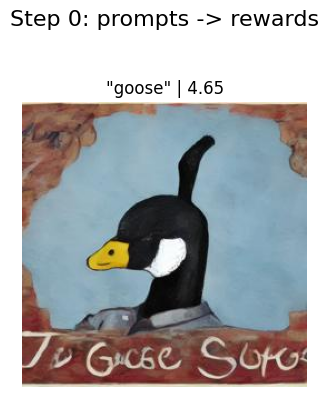

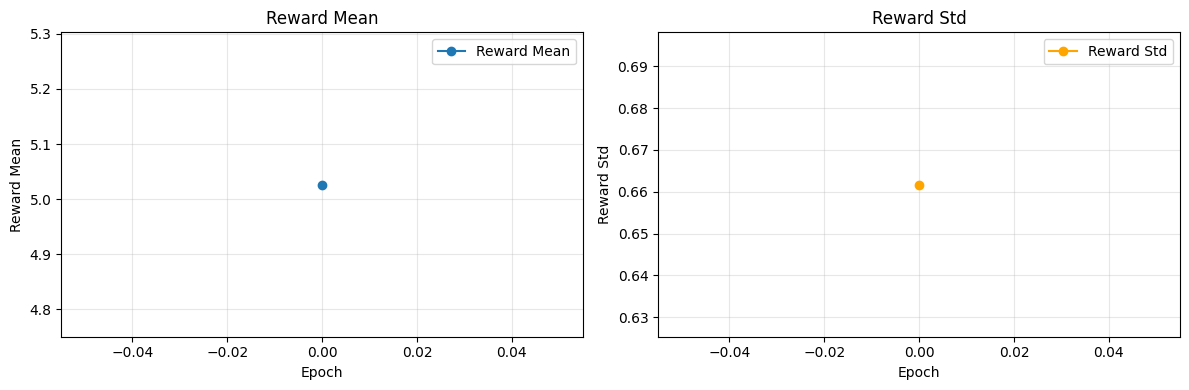

Epoch 0.0: training:   0%|          | 0/4 [00:00<?, ?it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 0>:311                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:1634 in backward               │
│                                                                                                  │
│   1631 │   │   elif self.distributed_type == DistributedType.MEGATRON_LM:                        │
│   1632 │   │   │   return                                                                        │
│   1633 │   │   elif self.scaler is not None:                                                     │
│ ❱ 1634 │   │   │   self.scaler.scale(loss).backward(**kwargs)                                    │
│   1635 │   │   else:                                                                             │
│   1636 │   │   │   loss.backward(**kwargs)                                                       │
│   1637                                                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.11/dist-packages/torch/_tensor.py:626 in backward                         │
│                                                                                                  │
│    623 │   │   │   │   create_graph=create_graph,                                                │
│    624 │   │   │   │   inputs=inputs,                                                            │
│    625 │   │   │   )                                                                             │
│ ❱  626 │   │   torch.autograd.backward(                                                          │
│    627 │   │   │   self, gradient, retain_graph, create_graph, inputs=inputs                     │
│    628 │   │   )                                                                                 │
│    629                                                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.11/dist-packages/torch/autograd/__init__.py:347 in backward               │
│                                                                                                  │
│   344 │   # The reason we repeat the same comment below is that                                  │
│   345 │   # some Python versions print out the first line of a multi-line function               │
│   346 │   # calls in the traceback and some print out the last line                              │
│ ❱ 347 │   _engine_run_backward(                                                                  │
│   348 │   │   tensors,                                                                           │
│   349 │   │   grad_tensors_,                                                                     │
│   350 │   │   retain_graph,                                                                      │
│                                                                                                  │
│ /usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823 in _engine_run_backward      │
│                                                                                                  │
│   820 │   if attach_logging_hooks:                                                               │
│   821 │   │   unregister_hooks = _register_logging_hooks_on_whole_graph(t_outputs)               │
│   822 │   try:                                                                                   │
│ ❱ 823 │   │   return Variable._execution_engine.run_backward(  # Calls into the C++ engine to    │
│   824 │   │   │   t_outputs, *args, **kwargs               

In [37]:
# @title
# Train!
samples_per_epoch = (
    config.sample.batch_size
    * accelerator.num_processes
    * config.sample.num_batches_per_epoch
)
total_train_batch_size = (
    config.train.batch_size
    * accelerator.num_processes
    * config.train.gradient_accumulation_steps
)

logger.info("***** Running training *****")
logger.info(f"  Num Epochs = {config.num_epochs}")
logger.info(f"  Sample batch size per device = {config.sample.batch_size}")
logger.info(f"  Train batch size per device = {config.train.batch_size}")
logger.info(
    f"  Gradient Accumulation steps = {config.train.gradient_accumulation_steps}"
)
logger.info("")
logger.info(f"  Total number of samples per epoch = {samples_per_epoch}")
logger.info(
    f"  Total train batch size (w. parallel, distributed & accumulation) = {total_train_batch_size}"
)
logger.info(
    f"  Number of gradient updates per inner epoch = {samples_per_epoch // total_train_batch_size}"
)
logger.info(f"  Number of inner epochs = {config.train.num_inner_epochs}")

assert config.sample.batch_size >= config.train.batch_size
assert config.sample.batch_size % config.train.batch_size == 0
assert samples_per_epoch % total_train_batch_size == 0

if config.resume_from:
    logger.info(f"Resuming from {config.resume_from}")
    accelerator.load_state(config.resume_from)
    first_epoch = int(config.resume_from.split("_")[-1]) + 1
else:
    first_epoch = 0

global_step = 0
for epoch in range(first_epoch, config.num_epochs):
    #################### SAMPLING ####################
    pipeline.unet.eval()
    samples = []
    prompts = []
    for i in tqdm(
        range(config.sample.num_batches_per_epoch),
        desc=f"Epoch {epoch}: sampling",
        disable=not accelerator.is_local_main_process,
        position=0,
    ):
        # generate prompts
        prompts, prompt_metadata = zip(
            *[
                prompt_fn(**config.prompt_fn_kwargs)
                for _ in range(config.sample.batch_size)
            ]
        )

        # encode prompts
        prompt_ids = pipeline.tokenizer(
            prompts,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=pipeline.tokenizer.model_max_length,
        ).input_ids.to(accelerator.device)
        prompt_embeds = pipeline.text_encoder(prompt_ids)[0]

        # sample
        with autocast():
            images, _, latents, log_probs = pipeline_with_logprob(
                pipeline,
                prompt_embeds=prompt_embeds,
                negative_prompt_embeds=sample_neg_prompt_embeds,
                num_inference_steps=config.sample.num_steps,
                guidance_scale=config.sample.guidance_scale,
                eta=config.sample.eta,
                output_type="pt",
            )

        latents = torch.stack(
            latents, dim=1
        )  # (batch_size, num_steps + 1, 4, 64, 64)
        log_probs = torch.stack(log_probs, dim=1)  # (batch_size, num_steps, 1)
        timesteps = pipeline.scheduler.timesteps.repeat(
            config.sample.batch_size, 1
        )  # (batch_size, num_steps)

        # compute rewards asynchronously
        rewards = executor.submit(reward_fn, images, prompts, prompt_metadata)
        # yield to to make sure reward computation starts
        time.sleep(0)

        samples.append(
            {
                "prompt_ids": prompt_ids,
                "prompt_embeds": prompt_embeds,
                "timesteps": timesteps,
                "latents": latents[
                    :, :-1
                ],  # each entry is the latent before timestep t
                "next_latents": latents[
                    :, 1:
                ],  # each entry is the latent after timestep t
                "log_probs": log_probs,
                "rewards": rewards,
            }
        )

    # wait for all rewards to be computed
    for sample in tqdm(
        samples,
        desc="Waiting for rewards",
        disable=not accelerator.is_local_main_process,
        position=0,
    ):
        rewards, reward_metadata = sample["rewards"].result()
        # accelerator.print(reward_metadata)
        sample["rewards"] = torch.as_tensor(rewards, device=accelerator.device)

    # collate samples into dict where each entry has shape (num_batches_per_epoch * sample.batch_size, ...)
    samples = {k: torch.cat([s[k] for s in samples]) for k in samples[0].keys()}

    # this is a hack to force wandb to log the images as JPEGs instead of PNGs
    with tempfile.TemporaryDirectory() as tmpdir:
        for i, image in enumerate(images):
            pil = Image.fromarray(
                (image.cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8)
            )
            pil = pil.resize((256, 256))
            pil.save(os.path.join(tmpdir, f"{i}.jpg"))
        # accelerator.log(
        #     {
        #         "images": [
        #             wandb.Image(
        #                 os.path.join(tmpdir, f"{i}.jpg"),
        #                 caption=f"{prompt:.25} | {reward:.2f}",
        #             )
        #             for i, (prompt, reward) in enumerate(
        #                 zip(prompts, rewards)
        #             )  # only log rewards from process 0
        #         ],
        #     },
        #     step=global_step,
        # )
        visualize_batch(tmpdir, prompts, rewards, global_step)

    # gather rewards across processes
    rewards = accelerator.gather(samples["rewards"]).cpu().numpy()

    # log rewards and images
    # accelerator.log(
    #     {
    #         "reward": rewards,
    #         "epoch": epoch,
    #         "reward_mean": rewards.mean(),
    #         "reward_std": rewards.std(),
    #     },
    #     step=global_step,
    # )
    plot_reward(rewards_mean=rewards.mean(), rewards_std=rewards.std(), step_numbers=global_step)

    # per-prompt mean/std tracking
    if config.per_prompt_stat_tracking:
        # gather the prompts across processes
        prompt_ids = accelerator.gather(samples["prompt_ids"]).cpu().numpy()
        prompts = pipeline.tokenizer.batch_decode(
            prompt_ids, skip_special_tokens=True
        )
        advantages = stat_tracker.update(prompts, rewards)
    else:
        advantages = (rewards - rewards.mean()) / (rewards.std() + 1e-8)

    # ungather advantages; we only need to keep the entries corresponding to the samples on this process
    samples["advantages"] = (
        torch.as_tensor(advantages)
        .reshape(accelerator.num_processes, -1)[accelerator.process_index]
        .to(accelerator.device)
    )

    del samples["rewards"]
    del samples["prompt_ids"]

    total_batch_size, num_timesteps = samples["timesteps"].shape
    assert (
        total_batch_size
        == config.sample.batch_size * config.sample.num_batches_per_epoch
    )
    assert num_timesteps == config.sample.num_steps

    #################### TRAINING ####################
    for inner_epoch in range(config.train.num_inner_epochs):
        # shuffle samples along batch dimension
        perm = torch.randperm(total_batch_size, device=accelerator.device)
        samples = {k: v[perm] for k, v in samples.items()}

        # shuffle along time dimension independently for each sample
        perms = torch.stack(
            [
                torch.randperm(num_timesteps, device=accelerator.device)
                for _ in range(total_batch_size)
            ]
        )
        for key in ["timesteps", "latents", "next_latents", "log_probs"]:
            samples[key] = samples[key][
                torch.arange(total_batch_size, device=accelerator.device)[:, None],
                perms,
            ]

        # rebatch for training
        samples_batched = {
            k: v.reshape(-1, config.train.batch_size, *v.shape[1:])
            for k, v in samples.items()
        }

        # dict of lists -> list of dicts for easier iteration
        samples_batched = [
            dict(zip(samples_batched, x)) for x in zip(*samples_batched.values())
        ]

        # train
        pipeline.unet.train()
        info = defaultdict(list)
        for i, sample in tqdm(
            list(enumerate(samples_batched)),
            desc=f"Epoch {epoch}.{inner_epoch}: training",
            position=0,
            disable=not accelerator.is_local_main_process,
        ):
            if config.train.cfg:
                # concat negative prompts to sample prompts to avoid two forward passes
                embeds = torch.cat(
                    [train_neg_prompt_embeds, sample["prompt_embeds"]]
                )
            else:
                embeds = sample["prompt_embeds"]

            for j in tqdm(
                range(num_train_timesteps),
                desc="Timestep",
                position=1,
                leave=False,
                disable=not accelerator.is_local_main_process,
            ):
                with accelerator.accumulate(unet):
                    with autocast():
                        if config.train.cfg:
                            noise_pred = unet(
                                torch.cat([sample["latents"][:, j]] * 2),
                                torch.cat([sample["timesteps"][:, j]] * 2),
                                embeds,
                            ).sample
                            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                            noise_pred = (
                                noise_pred_uncond
                                + config.sample.guidance_scale
                                * (noise_pred_text - noise_pred_uncond)
                            )
                        else:
                            noise_pred = unet(
                                sample["latents"][:, j],
                                sample["timesteps"][:, j],
                                embeds,
                            ).sample
                        # compute the log prob of next_latents given latents under the current model
                        _, log_prob = ddim_step_with_logprob(
                            pipeline.scheduler,
                            noise_pred,
                            sample["timesteps"][:, j],
                            sample["latents"][:, j],
                            eta=config.sample.eta,
                            prev_sample=sample["next_latents"][:, j],
                        )

                    # ppo logic
                    advantages = torch.clamp(
                        sample["advantages"],
                        -config.train.adv_clip_max,
                        config.train.adv_clip_max,
                    )
                    ratio = torch.exp(log_prob - sample["log_probs"][:, j])
                    unclipped_loss = -advantages * ratio
                    clipped_loss = -advantages * torch.clamp(
                        ratio,
                        1.0 - config.train.clip_range,
                        1.0 + config.train.clip_range,
                    )
                    loss = torch.mean(torch.maximum(unclipped_loss, clipped_loss))

                    # debugging values
                    # John Schulman says that (ratio - 1) - log(ratio) is a better
                    # estimator, but most existing code uses this so...
                    # http://joschu.net/blog/kl-approx.html
                    info["approx_kl"].append(
                        0.5
                        * torch.mean((log_prob - sample["log_probs"][:, j]) ** 2)
                    )
                    info["clipfrac"].append(
                        torch.mean(
                            (
                                torch.abs(ratio - 1.0) > config.train.clip_range
                            ).float()
                        )
                    )
                    info["loss"].append(loss)

                    # backward pass
                    accelerator.backward(loss)
                    if accelerator.sync_gradients:
                        accelerator.clip_grad_norm_(
                            unet.parameters(), config.train.max_grad_norm
                        )
                    optimizer.step()
                    optimizer.zero_grad()

                # Checks if the accelerator has performed an optimization step behind the scenes
                if accelerator.sync_gradients:
                    assert (j == num_train_timesteps - 1) and (
                        i + 1
                    ) % config.train.gradient_accumulation_steps == 0
                    # log training-related stuff
                    info = {k: torch.mean(torch.stack(v)) for k, v in info.items()}
                    info = accelerator.reduce(info, reduction="mean")
                    info.update({"epoch": epoch, "inner_epoch": inner_epoch})
                    # accelerator.log(info, step=global_step)
                    global_step += 1
                    info = defaultdict(list)

        # make sure we did an optimization step at the end of the inner epoch
        assert accelerator.sync_gradients

    if epoch != 0 and epoch % config.save_freq == 0 and accelerator.is_main_process:
        accelerator.save_state()


# if __name__ == "__main__":
#     app.run(main)